# f-MRI Tumour Classification

In [130]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Get the data

We shall be using a dataset of f-MRI scans of humans with and without brain tumors; they are in the `/data/yes` and `/data/no` directories respectively.

In [29]:
pos_dir = "data/yes"
neg_dir = "data/no"

pos_imgs = np.array([cv.imread('{0}/{1}'.format(pos_dir, filepath),0) for filepath in os.listdir(pos_dir)])
neg_imgs = np.array([cv.imread('{0}/{1}'.format(neg_dir, filepath),0) for filepath in os.listdir(neg_dir)])

Images are of different sizes, so we will reshape them.

We will find the minimum height and width for all of the images and reshape all images to those dimensions.

In [36]:
min_h = pos_imgs[0].shape[0]
min_w = pos_imgs[0].shape[1]

for img in np.append(pos_imgs, neg_imgs):
    if (img.shape[0] < min_h):
        min_h = img.shape[0]
    if (img.shape[1] < min_w):
        min_w = img.shape[1]

print(f"images to be shaped to ({min_h}, {min_w})")

images to be shaped to (168, 150)


We can now reshape all of the images.

In [47]:
X_pos = np.asarray([cv.resize(img, (min_w, min_h)) for img in pos_imgs])
X_neg = np.asarray([cv.resize(img, (min_w, min_h)) for img in neg_imgs])

print(f"Postivies: {X_pos.shape[0]} * ({X_pos.shape[1]}, {X_pos.shape[2]})")
print(f"Negatives:  {X_neg.shape[0]} * ({X_neg.shape[1]}, {X_neg.shape[2]})")

Postivies: 155 * (168, 150)
Negatives:  98 * (168, 150)


We now have 155 positives and 98 negatives all of dimensions 150x168.

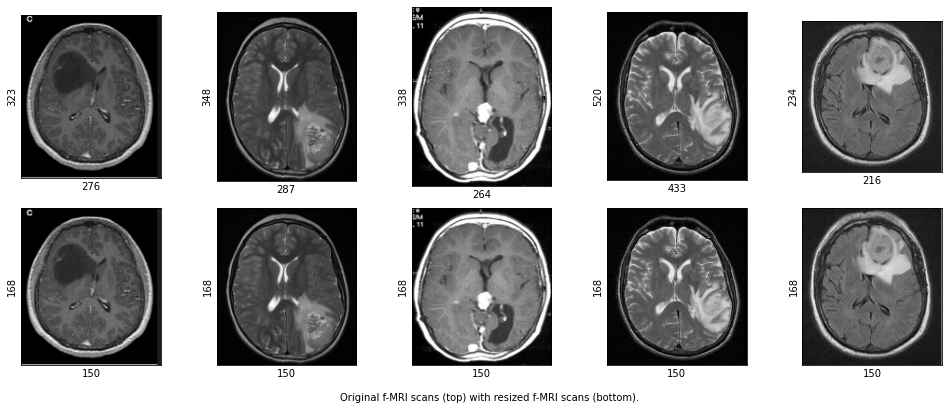

In [107]:
def plot_resized_images(orig_imgs, resized_imgs, title, text, num=5):
    fig = plt.figure(figsize=(20, 12))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    indices = np.random.choice(len(orig_imgs), num)
    for i, ind in enumerate(indices):
        ax = fig.add_subplot(1, num+1, i+1)
        ax.imshow(orig_imgs[ind], cmap='gray')
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.set_xlabel(orig_imgs[ind].shape[1])
        ax.set_ylabel(orig_imgs[ind].shape[0])
    for i, ind in enumerate(indices):
        ax = fig.add_subplot(2, num+1, i+num+2)
        ax.imshow(resized_imgs[ind], cmap='gray')
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.set_xlabel(resized_imgs[ind].shape[1])
        ax.set_ylabel(resized_imgs[ind].shape[0])
    fig.text(0.45, 0.15, text, ha="center")

title = "f-MRI Scans of Brain Tumor Patients"
text = "Original f-MRI scans (top) with resized f-MRI scans (bottom)."
plot_resized_images(pos_imgs, X_pos, title, text)

We shall combine the positive and negative samples into one feature array `X`. We shall also create a label array `y` to retain class information.

In [144]:
X = np.vstack((X_pos, X_neg))
print(f"{X.shape[0]} * ({X.shape[2]}, {X.shape[1]}) images\n")

y_pos = np.ones((X_pos.shape[0]))
y_neg = np.zeros((X_neg.shape[0]))
y = np.append(y_pos, y_neg)
print(f"{y.shape[0]} labels - {y_pos.size} positive, {y_neg.size} negative")

253 * (150, 168) images

253 labels - 155 positive, 98 negative


The data is now combined, but we've done it in a way where all positives are followed by all negatives. It is a good idea to shuffle them so it does not decide all images are postive in the first half of training. `sklearn.utils.shuffle` does this, but we also wish to create training and test sets and `sklearn.model_selection.train_test_split` sets its `shuffle` parameter to `True` by default which will do the same thing. We shall also take a small validation set from the training set.

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(f"train size: {X_train.shape[0]}, validation size: {X_val.shape[0]}, test size: {X_test.shape[0]}")

train size: 181, validation size: 21, test size: 51


The data is now ready for an initial machine learning model.

Based on performance there are some other preprocessing steps that may help, such as:
- creating a flipped version of each image to increase training set size
- applying a small Gaussian blur kernel to each image
- image brightness could be normalised across the images
- some images have small labels in the corners which could be removed
- removing positive samples so there is an equal number of classes